# Continuous Wavelet Transforms

In this module, we'll address continuous wavelet transforms (CWTs) using a variety of datasets. This approach involves decomposing a signal into wavelets, which, unlike the sines and cosines used during a Fourier transform, are highly localized in time. This allows CWTs to yield acoustic representations offering high temporal and spectral resolutions.

Interestingly, [this paper](https://link.springer.com/article/10.1007/s00521-018-3626-7) demonstrated that though less commonly implemented than STFT-based spectrograms, wavelet transforms provide key advantages for machine learning applications, especially when generalizing to new datasets.

For more information, a thorough guide to wavelet transforms can be found by clicking [here](http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/).

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import pywt
from scipy import interpolate

import warnings
warnings.simplefilter('ignore', FutureWarning)

## Watkins Sperm Whale Click

For a first practical example, we'll apply this technique to a sperm whale click. We begin by loading the data.

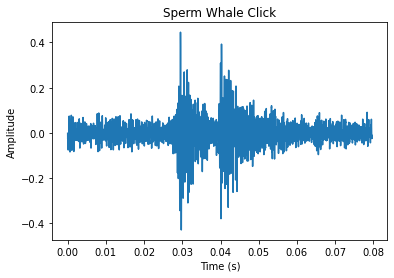

In [3]:
file = 'data/WatkinsPMacro.wav'
wf, sr_sw = sf.read(file)
signal_sw = wf[31000:37500]
time_sw = np.linspace(0,len(signal_sw)/sr_sw,len(signal_sw))
T_sw = 1 / sr_sw

plt.plot(time_sw, signal_sw)
plt.title('Sperm Whale Click')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

For an initial pass, let's compute a CWT using a Morlet wavelet. In this case, we only have to specify the scales (frequencies) over which to compute the transform. We'll provide a few different visualizations including log compression. Firstly, we'll plot the absolute magnitude of the transform.

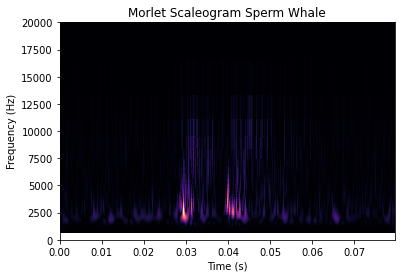

In [4]:
cwt_sw, freq_sw = pywt.cwt(signal_sw, np.arange(1, 128), 'morl', sampling_period = T_sw)
plt.pcolormesh(time_sw, freq_sw, np.abs(cwt_sw), vmin=0, cmap='magma')  
plt.ylim([0, 20000])
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.title("Morlet Scaleogram Sperm Whale")
plt.show()

Next, we'll carry out a log compression to convert the plot to decibel scale.

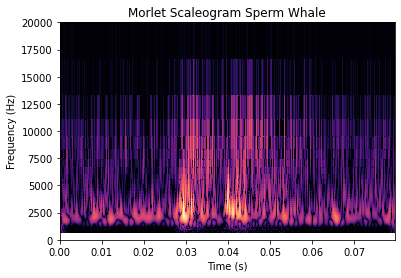

In [5]:
cwt_sw, freq_sw = pywt.cwt(signal_sw, np.arange(1, 128), 'morl', sampling_period = T_sw)
plt.pcolormesh(time_sw, freq_sw, 20*np.log10(np.abs(cwt_sw)**2+1e-4), cmap='magma')  
plt.ylim([0, 20000])
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.title("Morlet Scaleogram Sperm Whale")
plt.show()

Lastly, as is commonly done, we can plot the contours.

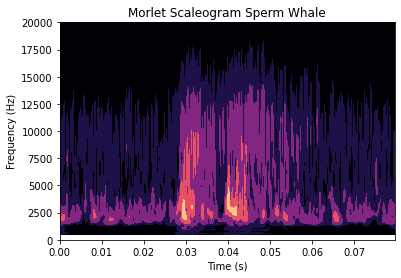

In [6]:
plt.contourf(time_sw, freq_sw, np.log10(np.abs(cwt_sw)**2+1e-7), vmin=-3, cmap='magma')
plt.ylim([0, 20000])
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.title("Morlet Scaleogram Sperm Whale")
plt.show()

Now, that we have these different options for visualizing, let's explore the various wavelets included in the Pywavelet module.

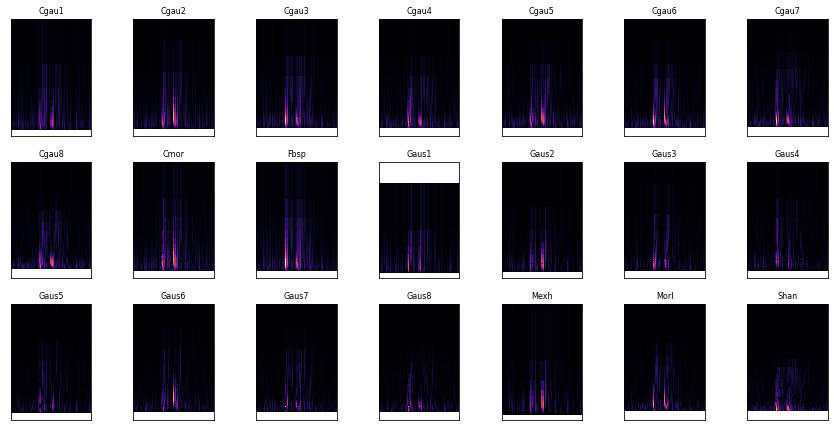

In [16]:
wavlist = pywt.wavelist(kind='continuous')
fig, axes = plt.subplots(3, 7, figsize=(12,6))
fig.tight_layout(pad=0.5)
axs = axes.flatten()
for i, wl in enumerate(wavlist):
    cwtmatr_sw, freqs_sw = pywt.cwt(signal_sw, np.arange(1, 128), wl, sampling_period = T_sw)
    axs[i].pcolormesh(time_sw, freqs_sw, np.abs(cwtmatr_sw), vmin=0, cmap = "magma" )  
    axs[i].set_ylim([0, 20000])
    axs[i].set_title(f'{wl.capitalize()}', fontsize=8)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

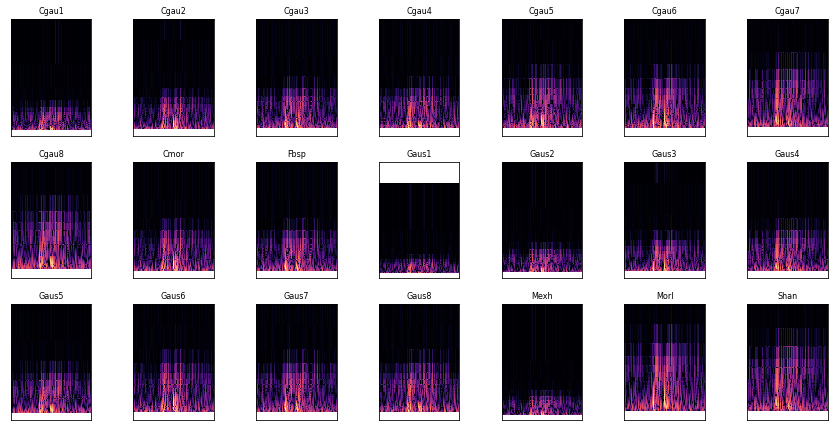

In [18]:
wavlist = pywt.wavelist(kind='continuous')
fig, axes = plt.subplots(3, 7, figsize=(12,6))
fig.tight_layout(pad=0.5)
axs = axes.flatten()
for i, wl in enumerate(wavlist):
    cwtmatr_sw, freqs_sw = pywt.cwt(signal_sw, np.arange(1, 128), wl, sampling_period = T_sw)
    axs[i].pcolormesh(time_sw, freqs_sw, 20*np.log10(np.abs(cwt_sw)**2+1e-4), cmap = "magma" )  
    axs[i].set_ylim([0, 20000])
    axs[i].set_title(f'{wl.capitalize()}', fontsize=8)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

Finally, we need to construct a complete preprocessing pipeline to yield arrays that we can feed into a CNN.

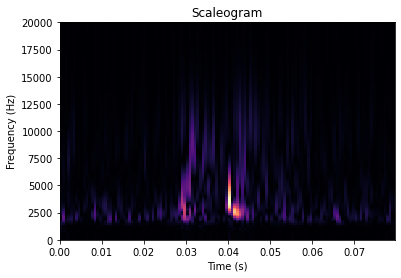

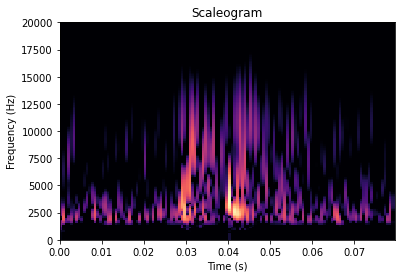

((6500,), (127,), (127, 6500), (128, 128), (128, 128), (128, 128))

In [62]:
class CWT(object):
    
    def __init__(self, scales=np.flip(np.arange(1, 128)), wavelet='morl', log_scale=False, db_th=1e-4): 
        self.scales = scales
        self.wavelet = wavelet
        self.log_scale = log_scale
        self.db_th = db_th
        
    def generate_representation(self, time, signal, res=128, fmax=20000):
        t, f, c = self.compute_cwt(time, signal)
        t, f, c = self.interp(t, f, c.T, res=res, fmax=fmax)
        c = c.T
        if self.log_scale is False:
            c = np.abs(c)
        else:
            c = np.log10(np.abs(c)**2 + self.db_th)
        return t, f, c
    
    def compute_cwt(self, time, signal):
        cwt, freq = pywt.cwt(signal, self.scales, self.wavelet, sampling_period = time[1] - time[0])
        return time, freq, cwt
    
    @staticmethod
    def interp(t, f, fx, res=128, fmax=None):
        if fmax is None:
            fmax = np.max(f)
            
        interpolator = interpolate.RectBivariateSpline(t, f, fx)

        t_interp = np.linspace(0, t[-1], res)
        f_interp = np.linspace(0, fmax, res)

        fx_interp = interpolator(t_interp, f_interp)

        tt, ff = np.meshgrid(t_interp, f_interp)
        return tt, ff, fx_interp
    
    def vis_representation(self, time, signal, res=128, fmax=20000, vmin=0):
        t, f, c = self.generate_representation(time, signal, res=res, fmax=fmax)
        plt.pcolormesh(t, f, c, cmap='magma', vmin=vmin)  
        plt.ylim([0, fmax])
        plt.ylabel("Frequency (Hz)")
        plt.xlabel("Time (s)")
        plt.title("Scaleogram")
        plt.show()
    
cwt = CWT(log_scale=False)
t0, f0, c0 = cwt.compute_cwt(time_sw, signal_sw)
t, f, c = cwt.generate_representation(time_sw, signal_sw)
cwt.vis_representation(time_sw, signal_sw)

cwt = CWT(log_scale=True)
t0, f0, c0 = cwt.compute_cwt(time_sw, signal_sw)
t, f, c = cwt.generate_representation(time_sw, signal_sw)
cwt.vis_representation(time_sw, signal_sw, vmin=-3)
t0.shape, f0.shape, c0.shape, t.shape, f.shape, c.shape

t0.shape, f0.shape, c0.shape, t.shape, f.shape, c.shape

## Macaque Data

We'll now apply this CWT class to the macaque dataset used in module 07 in this toolkit.

In [71]:
from fastai2.vision.all import *
import re
import librosa
from sklearn.model_selection import train_test_split

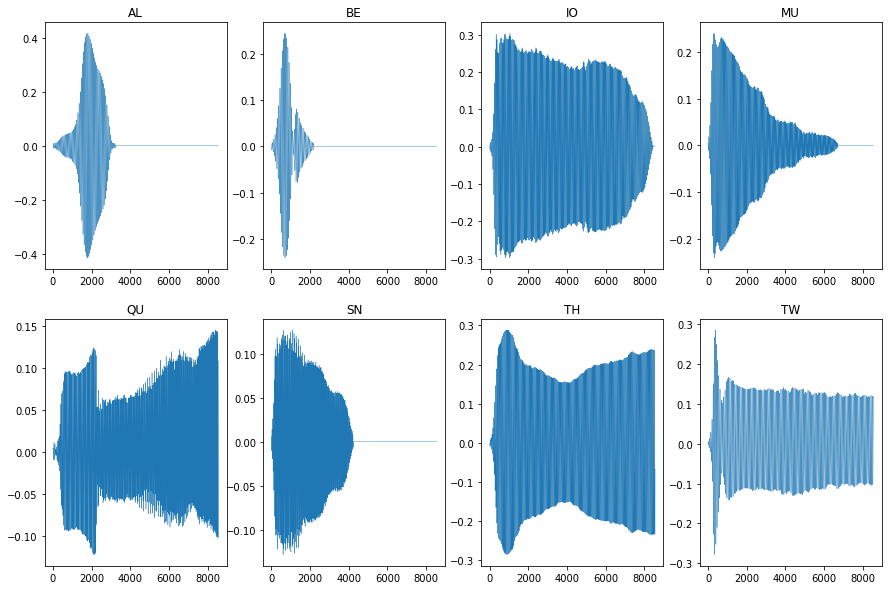

In [68]:
URL = 'https://storage.googleapis.com/ml-animal-sounds-datasets/macaques_24414Hz.zip'
class LoadData(object):
    
    def __init__(self, url=URL):
        self.url = url
        
    def construct_dataframe(self):
        path = untar_data(self.url)
        wav_files = get_files(path)

        wfs = []
        labels = []
        wavs = []

        for wav in wav_files:
            call_code = re.split('/', str(wav))[-2]
            wf, _ = sf.read(wav)

            wfs.append(wf)
            labels.append(call_code)
            wavs.append(wav)

        call_dict = {l: i for i, l in enumerate(np.unique(labels))}
        call_category = [call_dict[i] for i in labels]
        data_df = pd.DataFrame({'Waveform':wfs, 'Path': wavs, 'Label': labels, 'Category': call_category})
        
        return data_df
    
    def fixed_dataframe(self):
        
        dataframe = self.construct_dataframe()
        
        mean_dur = self.get_mean_duration(dataframe)
        paths = dataframe.Path.values
        labels = dataframe.Label.values
        categories = dataframe.Category.values
        waveforms = dataframe.Waveform.values

        xs = []
        for wf in waveforms:
            x = librosa.util.fix_length(wf, mean_dur)
            xs.append(x)
        fixed_df = pd.DataFrame({'Waveform':xs, 'Path': paths, 'Label':labels, 'Category':categories})    
        return fixed_df
    
    def balanced_dataframe(self):
    
        dataframe = self.fixed_dataframe()
        balanced_df = dataframe.groupby('Category')
        balanced_df = balanced_df.apply(lambda x: x.sample(balanced_df.size().min()).reset_index(drop=True))

        return balanced_df
    
    def visualize_classes(self, dataframe, group='Label'):
        df = dataframe.groupby(group).apply(lambda x: x.sample(1))
        df = df.reset_index(drop=True)

        fig, axes = plt.subplots(2,4, figsize=(15,10))
        for i, ax in enumerate(axes.flatten()):
            ax.plot(df.Waveform.iloc[i], linewidth=0.4)
            ax.set_title(df.Label.iloc[i])
        plt.show()
    
    @staticmethod
    def get_mean_duration(dataframe):
        waveforms = dataframe.Waveform.values
        durs = []
        for wf in waveforms:
            durs.append(wf.shape[0])
        mean_dur = int(np.mean(durs))
        return mean_dur
    
loader = LoadData()
data_df = loader.balanced_dataframe()
mean_dur = loader.get_mean_duration(data_df)
loader.visualize_classes(data_df)

In [69]:
MEAN_DURATION = mean_dur
WINDOW_WIDTH = MEAN_DURATION

In [72]:
X_numpy = np.zeros((len(data_df), MEAN_DURATION), dtype=np.float32)
for i, wf in enumerate(data_df.Waveform.values):
    X_numpy[i, :] = wf
Y=data_df.Category.values

X_train, X_test, Y_train, Y_test = train_test_split(X_numpy, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2995, 8549), (749, 8549), (2995,), (749,))

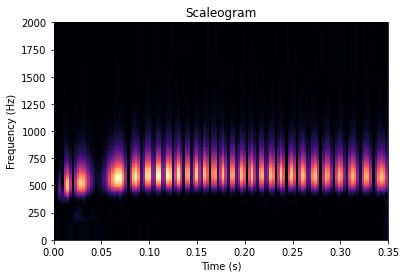

In [120]:
cwt = CWT(log_scale=False)
signal_m = X_train[0]
time_m = np.linspace(0,len(signal_m)/24414,len(signal_m))
cwt.vis_representation(time_m, signal_m, fmax=2000)

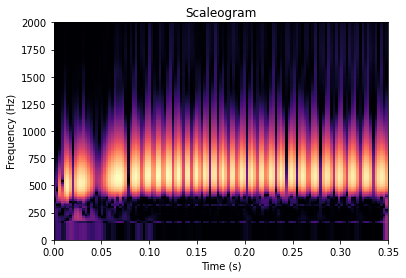

In [121]:
cwt = CWT(log_scale=True)
signal_m = X_train[0]
time_m = np.linspace(0,len(signal_m)/24414,len(signal_m))
cwt.vis_representation(time_m, signal_m, fmax=2000,vmin=-4)

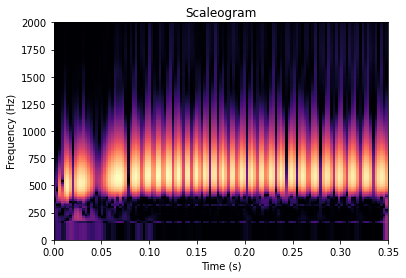

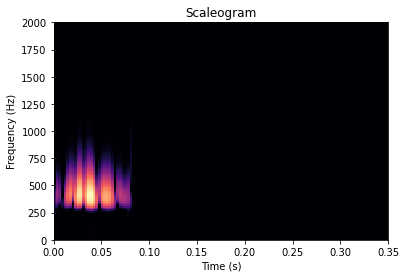

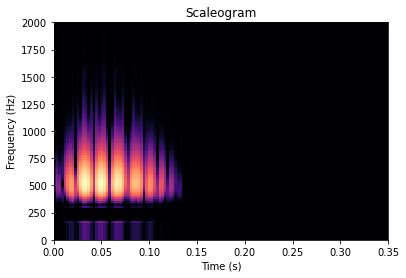

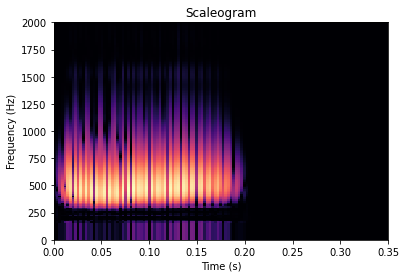

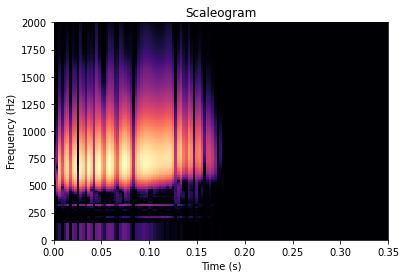

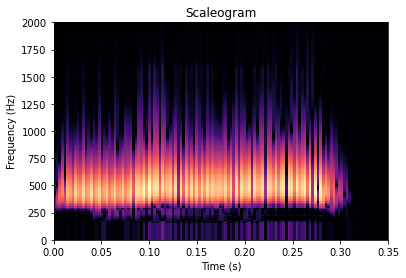

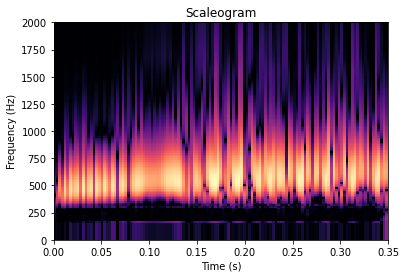

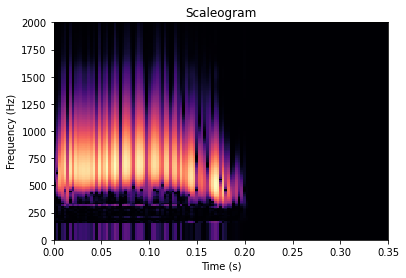

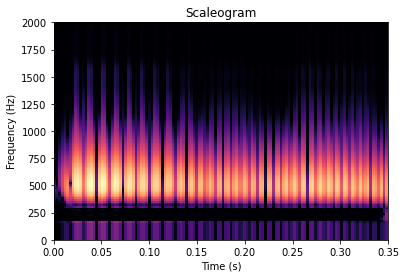

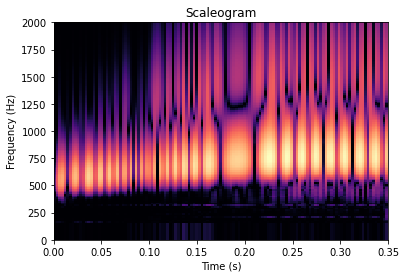

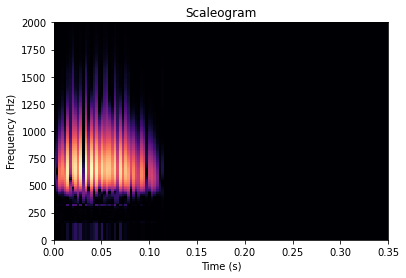

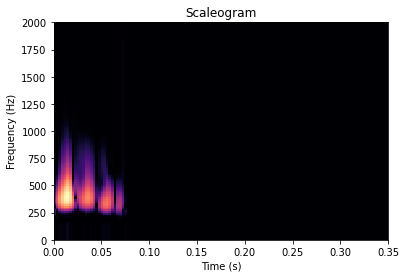

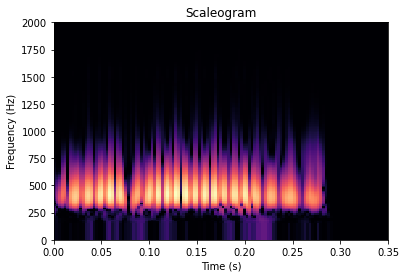

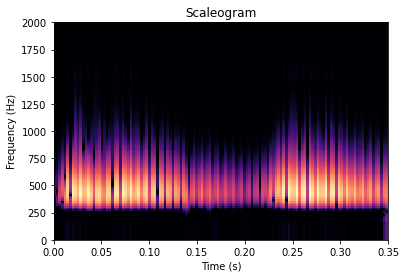

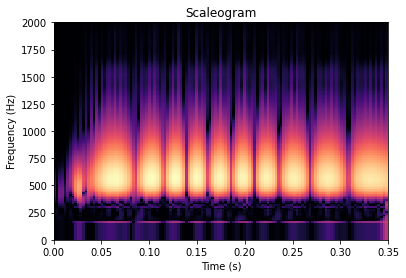

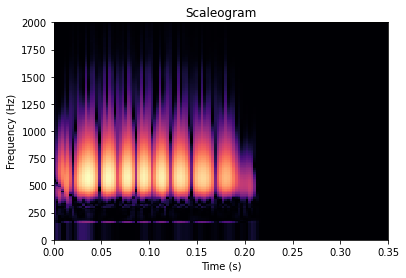

In [122]:
for n in range(16):
    cwt.vis_representation(time_m,X_train[n], fmax=2000,vmin=-4)

### Classification Task

In [118]:
import tensorflow as tf
with tf.device('/GPU:0'):
    print('GPU enabled')
tf.config.list_physical_devices()

GPU enabled


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [144]:
X_train_cwt = np.zeros((X_train.shape[0], 128, 128), dtype='float32')
X_train_cwt.shape

(2995, 128, 128)

In [145]:
import tqdm

In [146]:
cwt = CWT(log_scale=True)
t = np.linspace(0, WINDOW_WIDTH/24414, WINDOW_WIDTH)
for i in tqdm.tqdm(range(X_train_cwt.shape[0])):
    _, _, ci = cwt.generate_representation(t, X_train[i], fmax=2000)
    X_train_cwt[i] = ci
    

100%|██████████| 2995/2995 [15:01<00:00,  3.32it/s]


In [147]:
MAX=1
MIN=0

In [148]:
class MinMaxScaler(tf.keras.layers.Layer):
    def __init__(self, name='min_max_scaler', **kwargs):
        super(MinMaxScaler, self).__init__(name=name, **kwargs)

    def call(self, input_):
        return self.min_max_scaler(input_)

    @tf.function
    def min_max_scaler(self, x):
        batch, height, width = x.shape
        x = tf.cast(x, tf.float32)

        _min = tf.math.reduce_min(x, axis=2, keepdims=True, name=None)
        _min = tf.math.reduce_min(_min, axis=1, keepdims=True, name=None)

        _max = tf.math.reduce_max(x, axis=2, keepdims=True, name=None)
        _max = tf.math.reduce_max(_max, axis=1, keepdims=True, name=None)

        x_norm = (MAX - MIN) * (x - _min) / (_max - _min) + MIN
        return x_norm

    def get_config(self):
        config = super(MinMaxScaler, self).get_config()
        return config

In [149]:
RES=128
def build_baseline_classifier():
    inputs = tf.keras.Input(shape=(128,128))
    x = MinMaxScaler()(inputs)
    x = tf.keras.layers.Reshape((RES, RES, 1), input_shape=(RES, RES))(x)

    x = tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(3, 3),
                               activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(3, 3), 
                               activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(8, activation='softmax')(x)

    classifier = tf.keras.Model(inputs=inputs, outputs=outputs, name='baseline_classifier')
    return classifier

baseline_model = build_baseline_classifier()
baseline_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])
baseline_model.summary()

Model: "baseline_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128)]        0         
_________________________________________________________________
min_max_scaler (MinMaxScaler (None, 128, 128)          0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 62, 62, 64)

In [150]:
BATCH_SIZE=64
with tf.device('/GPU:0'):
    baseline_model.fit(X_train_cwt, Y_train,
                     batch_size=BATCH_SIZE,
                     epochs=15,
                     verbose=1,
                     validation_split=0.1)

Epoch 1/15
43/43 [==============================] - 6s 140ms/step - loss: 1.1003 - accuracy: 0.6631 - val_loss: 0.4713 - val_accuracy: 0.8100
Epoch 2/15
43/43 [==============================] - 6s 137ms/step - loss: 0.4998 - accuracy: 0.8382 - val_loss: 0.3843 - val_accuracy: 0.8567
Epoch 3/15
43/43 [==============================] - 6s 135ms/step - loss: 0.3547 - accuracy: 0.8887 - val_loss: 0.3270 - val_accuracy: 0.8867
Epoch 4/15
43/43 [==============================] - 6s 135ms/step - loss: 0.2803 - accuracy: 0.9117 - val_loss: 0.3221 - val_accuracy: 0.8833
Epoch 5/15
43/43 [==============================] - 6s 136ms/step - loss: 0.2319 - accuracy: 0.9284 - val_loss: 0.2654 - val_accuracy: 0.9067
Epoch 6/15
43/43 [==============================] - 6s 136ms/step - loss: 0.1441 - accuracy: 0.9488 - val_loss: 0.3022 - val_accuracy: 0.9167
Epoch 7/15
43/43 [==============================] - 6s 136ms/step - loss: 0.1123 - accuracy: 0.9666 - val_loss: 0.2741 - val_accuracy: 0.9033
Epoch 

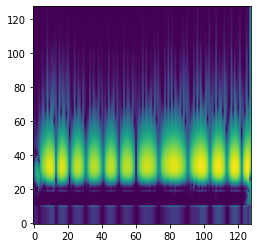

In [153]:
plt.imshow(X_train_cwt[1000])
plt.gca().invert_yaxis()

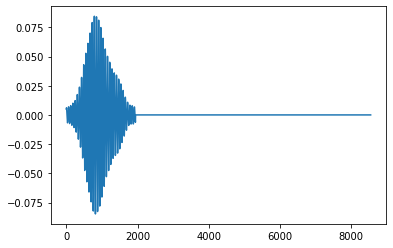

In [156]:
plt.plot(X_train[1])

In [167]:
scales = np.arange(1,128)
dt_mac = t[1] - t[0]
[coefficients, frequencies] = pywt.cwt(X_train[1], scales, 'morl', dt_mac)
print(frequencies)

[19834.05468476  9917.02734238  6611.35156159  4958.51367119
  3966.81093695  3305.67578079  2833.43638354  2479.25683559
  2203.78385386  1983.40546848  1803.09588043  1652.8378904
  1525.69651421  1416.71819177  1322.27031232  1239.6284178
  1166.7090991   1101.89192693  1043.89761499   991.70273424
   944.47879451   901.54794022   862.35020369   826.4189452
   793.36218739   762.84825711   734.59461795   708.35909588
   683.93292016   661.13515616   639.80821564   619.8142089
   601.03196014   583.35454955   566.68727671   550.94596347
   536.05553202   521.94880749   508.56550474   495.85136712
   483.75743134   472.23939726   461.25708569   450.77397011
   440.75677077   431.17510184   422.00116351   413.2094726
   404.77662622   396.6810937    388.90303303   381.42412855
   374.22744688   367.29730898   360.61917609   354.17954794
   347.96587166   341.96646008   336.17041839   330.56757808
   325.14843746   319.90410782   314.82626484   309.90710445
   305.13930284   300.5159800

(0.0, 2000.0)

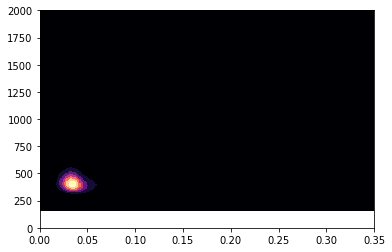

In [171]:
plt.contourf(t, frequencies, abs(coefficients)**2, extend='both',cmap='magma')
plt.ylim([0, 2000])

(0.0, 2000.0)

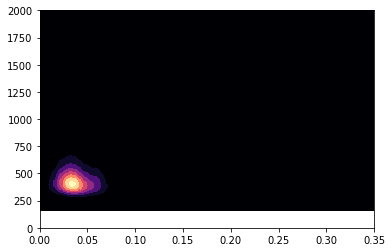

In [172]:
plt.contourf(t, frequencies, abs(coefficients), extend='both',cmap='magma')
plt.ylim([0, 2000])

(0.0, 2000.0)

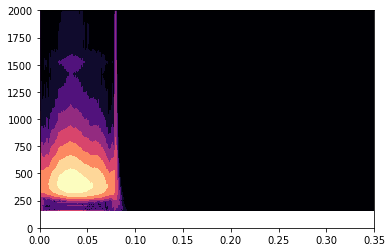

In [173]:
plt.contourf(t, frequencies, np.log10(abs(coefficients) + 1e-4), extend='both',cmap='magma')
plt.ylim([0, 2000])

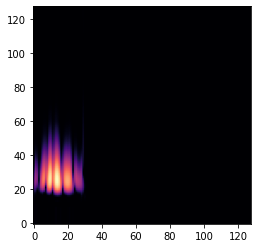

In [175]:
plt.imshow(X_train_cwt[1], cmap='magma')
plt.gca().invert_yaxis()

(0.0, 2000.0)

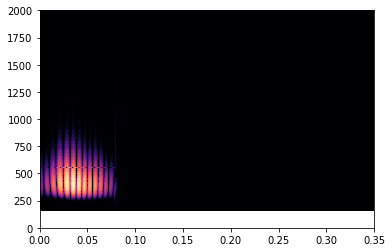

In [177]:
plt.pcolormesh(t, frequencies, np.log10(abs(coefficients)**2 + 1e-4), cmap='magma')
plt.ylim([0, 2000])

0.7263982382564634 -0.7212471868008516


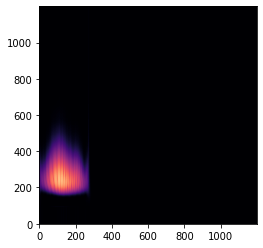

In [199]:
[coefficients, frequencies] = pywt.cwt(X_train[1], np.flip(scales), 'morl', dt_mac)   
interpolator = interpolate.RectBivariateSpline(t, frequencies, coefficients.T)

t_interp = np.linspace(0, t[-1], 1200)
f_interp = np.linspace(0, 2000, 1200)

fx_interp = interpolator(t_interp, f_interp).T
print(fx_interp.max(), fx_interp.min())
tt, ff = np.meshgrid(t_interp, f_interp)
plt.imshow(np.log10(abs(fx_interp)**2 + 1e-4), cmap='magma')
plt.gca().invert_yaxis()

In [115]:
class CWTLayer(tf.keras.layers.Layer):
    def __init__(self, name='spectrogram', **kwargs):
        super(CWTLayer, self).__init__(name=name, **kwargs)
        self.cwt = CWT(log_scale=True).generate_representation

    def call(self, x):
        t = np.linspace(0,len(x.numpy())/24414,len(x.numpy()))
        _, _, c = self.cwt(t, x.numpy(), fmax=5000)
        return tf.convert_to_tensor(c)

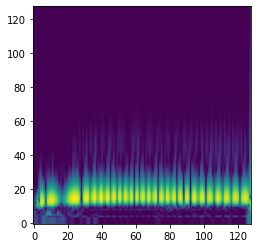

In [117]:
plt.imshow(CWTLayer()(X_train[0]).numpy())
plt.gca().invert_yaxis()

In [81]:
class CWTLayer(tf.keras.layers.Layer):
    def __init__(self, name='spectrogram', **kwargs):
        super(CWTLayer, self).__init__(name=name, **kwargs)

    def call(self, input_):
        return self.spectrogram_representation(input_)

    @tf.function
    def spectrogram_representation(self, x):

        def construct_spectrogram(signal, sr=SR, nfft=NFFT, hoplength=HOP_LENGTH, win=WINDOW, db_th=DB_TH):
            if hoplength is None:
                hoplength = nfft//16

            _, _, spec = librosa.reassigned_spectrogram(y=signal, sr=sr, n_fft=nfft, hop_length=hoplength, window=win)
            spec_db = librosa.power_to_db(spec, amin=db_th)
            f_bins = librosa.core.fft_frequencies(sr=sr, n_fft=nfft)
            t_bins = np.linspace(0, len(signal)/sr, spec[0].shape[0])
            return t_bins,f_bins, spec_db

        def interp_spectrogram(spec, t, f, res=RES, fmax=FMAX):
            if fmax is None:
                fmax = np.max(f)

            interp_fx = interpolate.interp2d(t, f, spec, kind='cubic')
            ts_interp = np.linspace(np.min(t), np.max(t), res)
            freqs_interp = np.linspace(np.min(f), fmax, res)
            spec_interp = interp_fx(ts_interp, freqs_interp)
            return spec_interp, freqs_interp, ts_interp

        def generate_representation(waveform, sr=SR, nfft=NFFT, db_th=DB_TH, win=WINDOW, res=RES, fmax=FMAX):
            batch_size= waveform.shape[0]
            reps = np.zeros((batch_size, res, res))
            for n in range(batch_size):
                t, f, Sxx = construct_spectrogram(waveform[n,:], sr=sr, nfft=nfft, win=win, db_th=db_th)
                rep, _, _ = interp_spectrogram(Sxx, t, f, res, fmax)
                reps[n, :, :] = rep
            return reps.astype('float32')

        @tf.function(input_signature=[tf.TensorSpec(None, tf.float32)])
        def tf_rep(input_):
            y = tf.numpy_function(generate_representation, [input_], tf.float32)
            return y

        x = tf.cast(x, tf.float32)
        result = (tf_rep(x))
        return tf.keras.backend.reshape(result, (-1, RES, RES))

    def get_config(self):
        config = super(SpecGram, self).get_config()
        return config

    def vis_rep(self, X_examples, Y_examples):
        N_examples = X_examples.shape[0]

        def is_sqrt(x):
            sq = np.sqrt(x)
            return (sq - np.floor(sq))==0

        if ~is_sqrt(N_examples):
            raise ValueError('Choose a perfect square number of examples')
        else:
            plot_dim = int(np.sqrt(N_examples))

        reps = self.spectrogram_representation(X_examples)
        fig, axes = plt.subplots(plot_dim, plot_dim, figsize=(15, 10))
        axs = axes.flatten()
        for n in range(N_examples):
            axs[n].imshow(reps[n, :, :].numpy(), cmap='magma')
            axs[n].invert_yaxis()
            axs[n].set_xticks([])
            axs[n].set_yticks([])
            axs[n].set_title(f'Class {Y_examples[n]}')

In [84]:
SpecGram()(X_train[0])

TypeError: 'method' object is not iterable

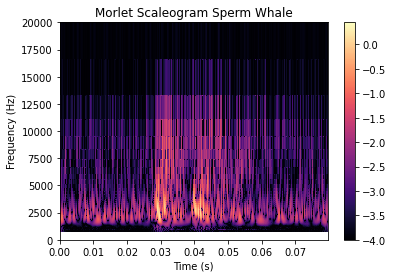

In [100]:
cwt_sw, freq_sw = pywt.cwt(signal_sw, np.arange(1, 128), 'morl', sampling_period = T_sw)
plt.pcolormesh(time_sw, freq_sw, np.log10(np.abs(cwt_sw)**2+1e-4), cmap='magma')  
plt.ylim([0, 20000])
plt.colorbar()
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.title("Morlet Scaleogram Sperm Whale")
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import pywt

In [3]:
path_name = '/home/peterbermant/.fastai/data/orchive-dataset.tar/call-catalog-xsilence/N01/A36-N01-062802-D004-12218.aiff'
signal_orca, sr_orca = sf.read(path_name)
time_orca = np.linspace(0,len(signal_orca)/sr_orca,len(signal_orca))
T_orca = 1 / sr_orca

In [31]:
file = 'data/WatkinsPMacro.wav'
wf, sr_sw = sf.read(file)
signal_sw = wf[31000:37500]
time_sw = np.linspace(0,len(signal_sw)/sr_sw,len(signal_sw))
T_sw = 1 / sr_sw

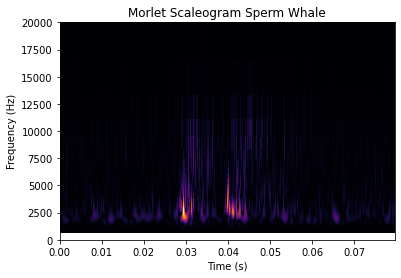

In [32]:
cwtmatr_sw, freqs_sw = pywt.cwt(signal_sw, np.arange(1, 128), "morl", sampling_period = T_sw)
fmax_sw, fmin_sw = pywt.scale2frequency('morl', 1)/T_sw, pywt.scale2frequency('morl', 128)/T_sw
plt.pcolormesh(time_sw, freqs_sw, np.abs(cwtmatr_sw), vmin=0, cmap = "inferno" )  
plt.ylim([0, 20000])
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.title("Morlet Scaleogram Sperm Whale")
plt.show()

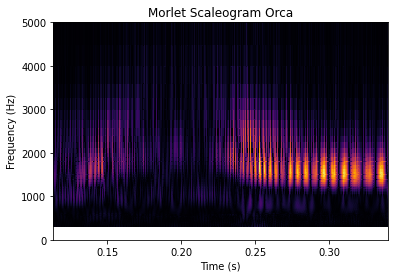

In [6]:
cwtmatr_orca, freqs_orca = pywt.cwt(signal_orca[5000:15000], np.arange(6, 512), "morl", sampling_period = T_orca)
fmax_orca, fmin_orca = pywt.scale2frequency('morl', 6)/T_orca, pywt.scale2frequency('morl', 512)/T_orca
plt.pcolormesh(time_orca[5000:15000], freqs_orca, np.abs(cwtmatr_orca), vmin=0, cmap = "inferno" )  
plt.ylim([0, 5000])
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.title("Morlet Scaleogram Orca")
plt.show()

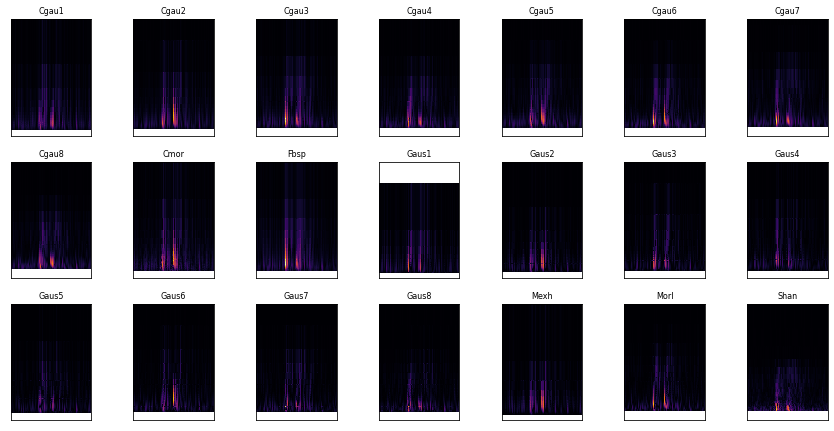

In [7]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

wavlist = pywt.wavelist(kind='continuous')
fig, axes = plt.subplots(3, 7, figsize=(12,6))
fig.tight_layout(pad=0.5)
axs = axes.flatten()
for i, wl in enumerate(wavlist):
    cwtmatr_sw, freqs_sw = pywt.cwt(signal_sw, np.arange(1, 128), wl, sampling_period = T_sw)
    axs[i].pcolormesh(time_sw, freqs_sw, np.abs(cwtmatr_sw), vmin=0, cmap = "inferno" )  
    axs[i].set_ylim([0, 20000])
    axs[i].set_title(f'{wl.capitalize()}', fontsize=8)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

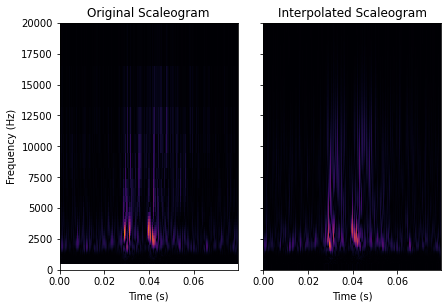

In [33]:
from scipy import interpolate
def interp_rep(ts, fs, rep, n_points=1000, ylim=20000):
    f = interpolate.RectBivariateSpline(ts, fs, rep)

    t_interp = np.linspace(0, ts[-1], n_points)
    f_interp = np.linspace(0, fs[-1], n_points)

    rep_interp = f(t_interp, f_interp)

    tt, ff = np.meshgrid(t_interp, f_interp)
    return tt, ff, rep_interp

ts_sw = time_sw
rep_sw, fs_sw = pywt.cwt(signal_sw, np.flip(np.arange(1, 128)), 'morl', sampling_period = T_sw)
tt_sw, ff_sw, rep_sw_in = interp_rep(ts_sw, fs_sw, rep_sw.T)
fig, axs = plt.subplots(1,2, sharey=True)
fig.tight_layout(pad = 1.0)
axs[0].pcolormesh(ts_sw, fs_sw, np.abs(rep_sw), cmap='inferno')
axs[0].set_ylabel('Frequency (Hz)')
axs[1].pcolormesh(tt_sw, ff_sw, np.abs(rep_sw_in.T), cmap='inferno')
for i, l in enumerate(['Original', 'Interpolated']):
    axs[i].set_ylim([0, 20000])
    axs[i].set_title(f'{l} Scaleogram')
    axs[i].set_xlabel('Time (s)')
plt.show()

In [34]:
from sklearn.decomposition import PCA
from itertools import count
def rep_goodness(rep, n_pca=150, th=0.95, vis=True):
    pca = PCA(n_components=n_pca)
    pca.fit(rep)
    
    sum_ = 0
    for feature_i in count():
        sum_ += pca.explained_variance_ratio_[feature_i]
        if sum_ > th:
            break
    if vis:
        print(f'Number of Features to Exceed Threshold th={th}: {feature_i+1}')
    
    return feature_i+1

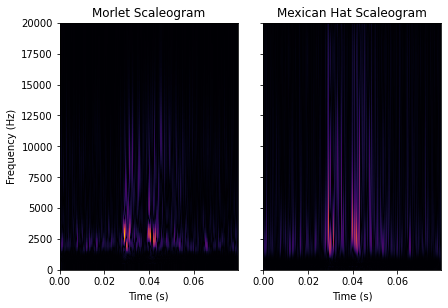

Number of Features to Exceed Threshold th=0.95: 6
Number of Features to Exceed Threshold th=0.95: 3


In [10]:
ts_morl = time_sw
rep_morl, fs_morl = pywt.cwt(signal_sw, np.flip(np.arange(1, 128)), 'morl', sampling_period = T_sw)
tt_morl, ff_morl, rep_morl_in = interp_rep(ts_morl, fs_morl, rep_morl.T)
rep_morl_in = rep_morl_in.T

ts_mexh = time_sw
rep_mexh, fs_mexh = pywt.cwt(signal_sw, np.flip(np.arange(1, 128)), 'mexh', sampling_period = T_sw)
tt_mexh, ff_mexh, rep_mexh_in = interp_rep(ts_mexh, fs_mexh, rep_mexh.T)
rep_mexh_in = rep_mexh_in.T

fig, axs = plt.subplots(1,2, sharey=True)
fig.tight_layout(pad = 1.0)
axs[0].pcolormesh(tt_morl, ff_morl, np.abs(rep_morl_in), cmap='inferno')
axs[0].set_ylabel('Frequency (Hz)')
axs[1].pcolormesh(tt_mexh, ff_mexh, np.abs(rep_mexh_in), cmap='inferno')
for i, l in enumerate(['Morlet', 'Mexican Hat']):
    axs[i].set_ylim([0, 20000])
    axs[i].set_title(f'{l} Scaleogram')
    axs[i].set_xlabel('Time (s)')
plt.show()

morl_goodness = rep_goodness(np.abs(rep_morl_in))
mexh_goodness = rep_goodness(np.abs(rep_mexh_in))

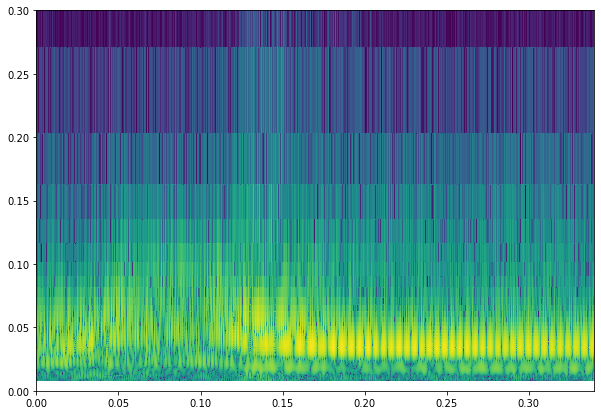

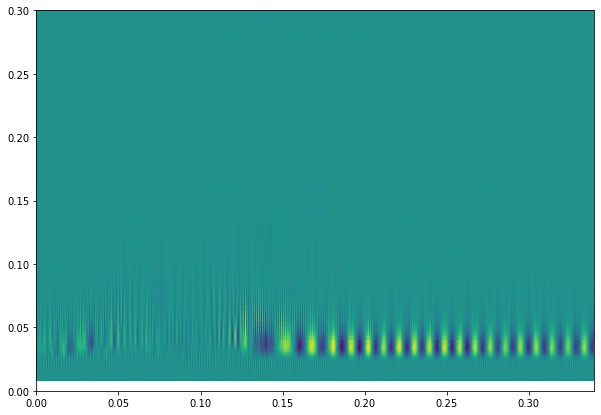

In [13]:
Ts = 1 /sr_orca
wavelet = 'morl'
scale = 32
sig_cwt = signal_orca[5000:20000]
freq_cwt = pywt.scale2frequency(wavelet, 4) / Ts
time_cwt = np.linspace(0, len(sig_cwt)/sr_orca, len(sig_cwt))


coef, freqs_cwt=pywt.cwt(sig_cwt,np.arange(1,256),'morl')

tt_cwt, ff_cwt = np.meshgrid(time_cwt, freqs_cwt)
plt.figure(figsize=(10,7))
plt.pcolormesh(tt_cwt, ff_cwt, 20*np.log10(np.abs(coef)+1e-4))
plt.ylim([0, 0.3])
plt.show()

plt.figure(figsize=(10,7))
plt.pcolormesh(tt_cwt, ff_cwt, coef)
plt.ylim([0, 0.3])
plt.show()

# Experimentation: 

http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

In [1]:
import os
import pywt
#from wavelets.wave_python.waveletFunctions import *
import itertools
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

In [11]:
dataset = "https://raw.githubusercontent.com/taspinar/siml/master/datasets/sst_nino3.dat.txt"
df_nino = pd.read_table(dataset)
N = df_nino.shape[0]
t0=1871
dt=0.25
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()

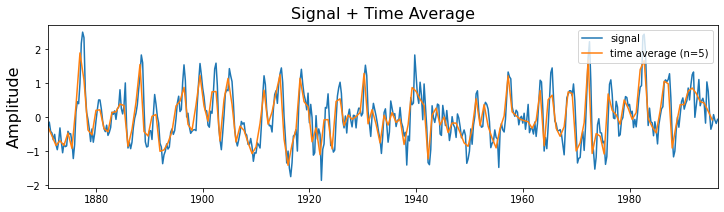

In [12]:
def get_ave_values(xvalues, yvalues, n = 5):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

def plot_signal_plus_average(ax, time, signal, average_over = 5):
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Amplitude', fontsize=16)
    ax.set_title('Signal + Time Average', fontsize=16)
    ax.legend(loc='upper right')

fig, ax = plt.subplots(figsize=(12,3))
plot_signal_plus_average(ax, time, signal, average_over = 3)
plt.show()

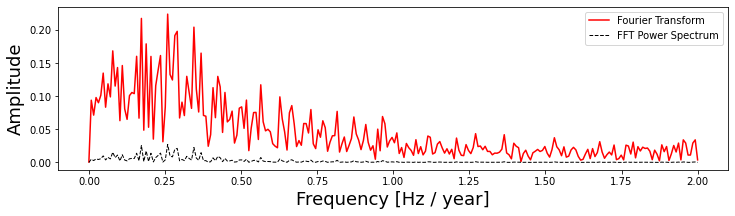

In [13]:
def get_fft_values(y_values, T, N, f_s):
    N2 = 2 ** (int(np.log2(N)) + 1) # round up to next highest power of 2
    f_values = np.linspace(0.0, 1.0/(2.0*T), N2//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N2 * np.abs(fft_values_[0:N2//2])
    return f_values, fft_values

def plot_fft_plus_power(ax, time, signal, plot_direction='horizontal', yticks=None, ylim=None):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2
    if plot_direction == 'horizontal':
        ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
        ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    elif plot_direction == 'vertical':
        scales = 1./f_values
        scales_log = np.log2(scales)
        ax.plot(fft_values, scales_log, 'r-', label='Fourier Transform')
        ax.plot(fft_power, scales_log, 'k--', linewidth=1, label='FFT Power Spectrum')
        ax.set_yticks(np.log2(yticks))
        ax.set_yticklabels(yticks)
        ax.invert_yaxis()
        ax.set_ylim(ylim[0], -1)
    ax.legend()

fig, ax = plt.subplots(figsize=(12,3))
ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
ax.set_ylabel('Amplitude', fontsize=18)
plot_fft_plus_power(ax, time, signal)
plt.show()


/home/peterbermant/.pyenv/versions/3.6.7/envs/venv/lib/python3.6/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


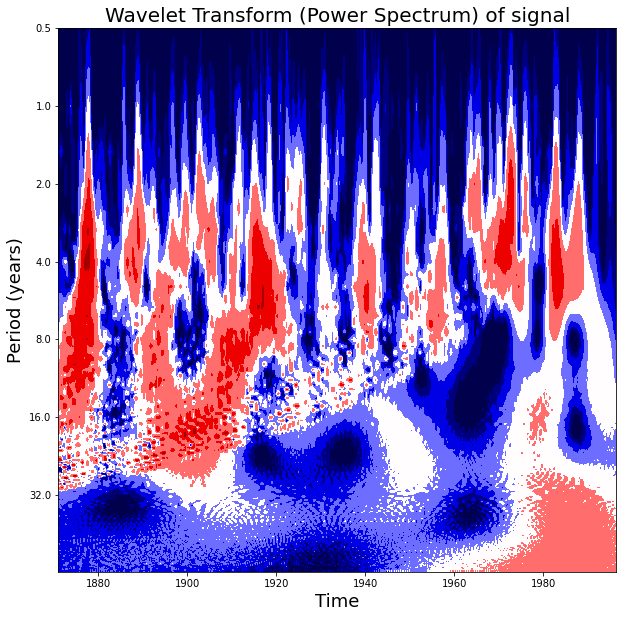

In [14]:
def plot_wavelet(ax, time, signal, scales, waveletname = 'cmor', 
                 cmap = plt.cm.seismic, title = '', ylabel = '', xlabel = ''):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    return yticks, ylim

scales = np.arange(1, 128)
title = 'Wavelet Transform (Power Spectrum) of signal'
ylabel = 'Period (years)'
xlabel = 'Time'

fig, ax = plt.subplots(figsize=(10, 10))
plot_wavelet(ax, time, signal, scales, xlabel=xlabel, ylabel=ylabel, title=title)
plt.show()

In [4]:
path_name = '/home/peterbermant/.fastai/data/orchive-dataset.tar/call-catalog-xsilence/N01/A36-N01-062802-D004-12218.aiff'
signal_orca, sr_orca = sf.read(path_name)
time_orca = np.linspace(0,len(signal_orca)/sr_orca,len(signal_orca))
T_orca = 1 / sr_orca

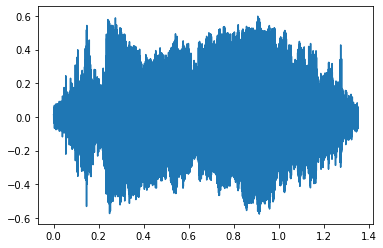

In [5]:
plt.plot(time_orca, signal_orca)
plt.show()

In [6]:
dt = time_orca[1]-time_orca[0]
dt

2.267611712066801e-05

In [7]:
scales = np.arange(1,128)
[coefficients, frequencies] = pywt.cwt(signal_orca, scales, 'morl', dt)
print(frequencies)

[35830.6492984  17915.3246492  11943.54976613  8957.6623246
  7166.12985968  5971.77488307  5118.66418549  4478.8311623
  3981.18325538  3583.06492984  3257.3317544   2985.88744153
  2756.20379218  2559.33209274  2388.70995323  2239.41558115
  2107.68525285  1990.59162769  1885.82364728  1791.53246492
  1706.22139516  1628.6658772   1557.85431732  1492.94372077
  1433.22597194  1378.10189609  1327.06108513  1279.66604637
  1235.53963098  1194.35497661  1155.82739672  1119.70779057
  1085.77725147  1053.84262642  1023.7328371    995.29581384
   968.39592698   942.91182364   918.73459739   895.76623246
   873.91827557   853.11069758   833.27091392   814.3329386
   796.23665108   778.92715866   762.35424039   746.47186038
   731.23774078   716.61298597   702.56175095   689.05094805
   676.04998676   663.53054256   651.46635088   639.83302319
   628.60788243   617.76981549   607.29914065   597.17748831
   587.38769342   577.91369836   568.74046505   559.85389529
   551.24075844   542.88862

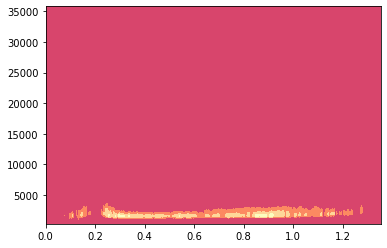

In [8]:
plt.contourf(time_orca, frequencies, coefficients, extend='both',cmap='magma')

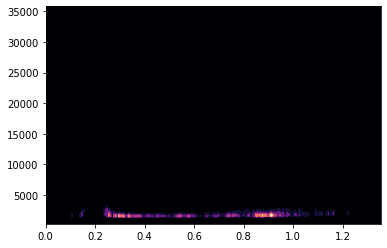

In [9]:
plt.contourf(time_orca, frequencies, abs(coefficients)**2, extend='both',cmap='magma')

In [10]:
np.min(abs(coefficients)**2)

2.7913843649689023e-18

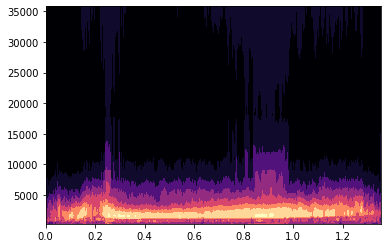

In [11]:
plt.contourf(time_orca, frequencies, np.log2(abs(coefficients)**2 + 1e-4), extend='both',cmap='magma')

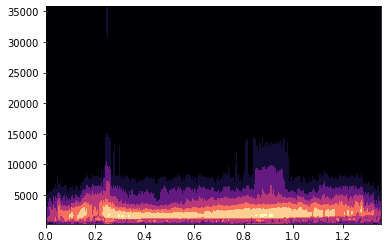

In [12]:
plt.contourf(time_orca, frequencies, np.log10(abs(coefficients)**2+ 1e-4), extend='both',cmap='magma')

(0.0, 5000.0)

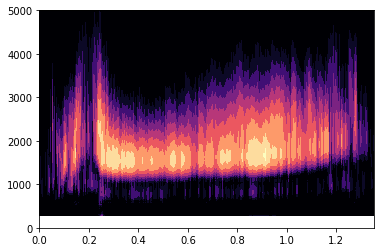

In [14]:
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
contourlevels = np.log10(levels)
plt.contourf(time_orca, frequencies, np.log10(abs(coefficients)**2+ 1e-4), contourlevels, extend='both',cmap='magma')
plt.ylim([0, 5000])

In [17]:
to_plot = np.log10(abs(coefficients)**2+ 1e-4)
to_plot.shape

(127, 59649)

In [44]:
from scipy import interpolate
def interp_rep(ts, fs, rep, n_points=1000, ylim=20000):
    f = interpolate.RectBivariateSpline(ts, fs, rep)

    t_interp = np.linspace(0, ts[-1], n_points)
    f_interp = np.linspace(0, ylim, n_points)

    rep_interp = f(t_interp, f_interp)

    tt, ff = np.meshgrid(t_interp, f_interp)
    return tt, ff, rep_interp

In [66]:
ts = time_orca
rep, fs = pywt.cwt(signal_orca, np.flip(np.arange(1, 128)), 'morl', sampling_period = T_orca)
tt, ff, rep_in = interp_rep(ts, fs, rep.T, n_points=6000, ylim=10000)
rep_in = rep_in.T

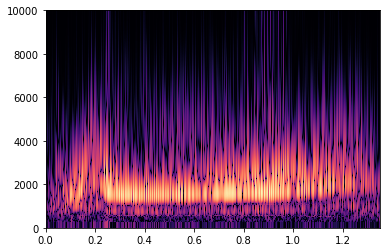

In [67]:
plt.pcolormesh(tt, ff, np.log10(abs(rep_in)**2 + 1e-4), cmap='magma')

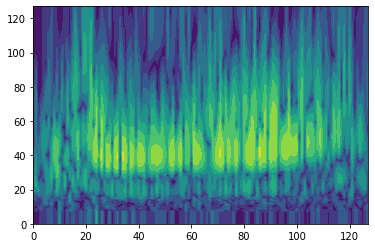

In [54]:
plt.contourf(np.log10(abs(rep_in)**2 + 1e-4))

(0.0, 5000.0)

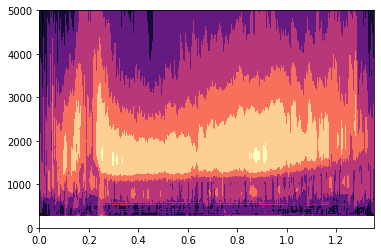

In [55]:
plt.contourf(time_orca, frequencies, np.log10(abs(coefficients)**2+ 1e-4), extend='both',cmap='magma')
plt.ylim([0, 5000])

In [ ]:
dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    return yticks, ylim

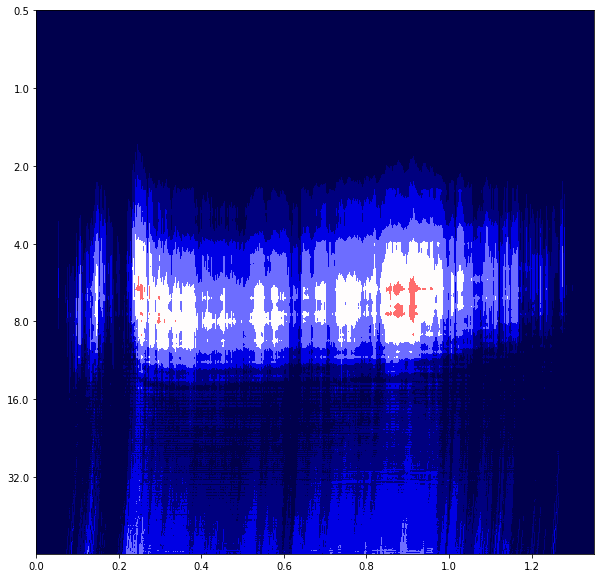

In [27]:
dt_orca = time_orca[1]-time_orca[0]
scales = np.arange(1,128)
waveletname='cmor'
dt=0.25
[coefficients, frequencies] = pywt.cwt(signal_orca, scales, waveletname, dt)
power = (abs(coefficients)) ** 2
period = 1. / frequencies
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
contourlevels = np.log2(levels)

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.contourf(time_orca, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=plt.cm.seismic)

yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
ax.set_yticks(np.log2(yticks))
ax.set_yticklabels(yticks)
ax.invert_yaxis()
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], -1)
plt.show()

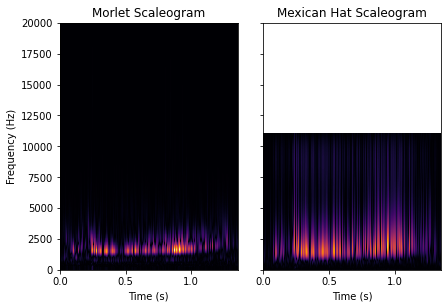

Number of Features to Exceed Threshold th=0.95: 2
Number of Features to Exceed Threshold th=0.95: 2


In [35]:
ts_morl = time_orca
rep_morl, fs_morl = pywt.cwt(signal_orca, np.flip(np.arange(1, 128)), 'morl', sampling_period = T_orca)
tt_morl, ff_morl, rep_morl_in = interp_rep(ts_morl, fs_morl, rep_morl.T)
rep_morl_in = rep_morl_in.T

ts_mexh = time_orca
rep_mexh, fs_mexh = pywt.cwt(signal_orca, np.flip(np.arange(1, 128)), 'mexh', sampling_period = T_orca)
tt_mexh, ff_mexh, rep_mexh_in = interp_rep(ts_mexh, fs_mexh, rep_mexh.T)
rep_mexh_in = rep_mexh_in.T

fig, axs = plt.subplots(1,2, sharey=True)
fig.tight_layout(pad = 1.0)
axs[0].pcolormesh(tt_morl, ff_morl, np.abs(rep_morl_in), cmap='inferno')
axs[0].set_ylabel('Frequency (Hz)')
axs[1].pcolormesh(tt_mexh, ff_mexh, np.abs(rep_mexh_in), cmap='inferno')
for i, l in enumerate(['Morlet', 'Mexican Hat']):
    axs[i].set_ylim([0, 20000])
    axs[i].set_title(f'{l} Scaleogram')
    axs[i].set_xlabel('Time (s)')
plt.show()

morl_goodness = rep_goodness(np.abs(rep_morl_in))
mexh_goodness = rep_goodness(np.abs(rep_mexh_in))

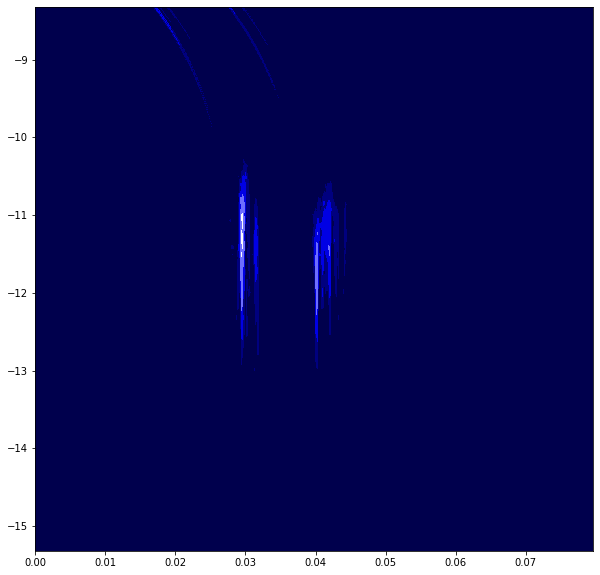

In [39]:
dt_sw = time_sw[1]-time_sw[0]
scales = np.arange(1,128)
waveletname='cmor'
dt=0.25
[coefficients, frequencies] = pywt.cwt(signal_sw, scales, waveletname, dt_sw)
power = (abs(coefficients)) ** 2
period = 1. / frequencies
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
contourlevels = np.log2(levels)

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.contourf(time_sw, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=plt.cm.seismic)

#yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
#ax.set_yticks(np.log2(yticks))
#ax.set_yticklabels(yticks)
#ax.invert_yaxis()
#ylim = ax.get_ylim()
#ax.set_ylim(ylim[0], -1)
plt.show()

In [8]:
import pandas as pd

In [1]:
import pywt
print(pywt.families(short=False))

['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
discrete_wavelets = ['db5', 'sym5', 'coif5', 'bior2.4']
continuous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']

list_list_wavelets = [discrete_wavelets, continuous_wavelets]
list_funcs = [pywt.Wavelet, pywt.ContinuousWavelet]

In [4]:
list_list_wavelets, list_funcs

([['db5', 'sym5', 'coif5', 'bior2.4'], ['mexh', 'morl', 'cgau5', 'gaus5']],
 [pywt._extensions._pywt.Wavelet, pywt._extensions._pywt.ContinuousWavelet])

/home/peterbermant/.pyenv/versions/3.6.7/envs/venv/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


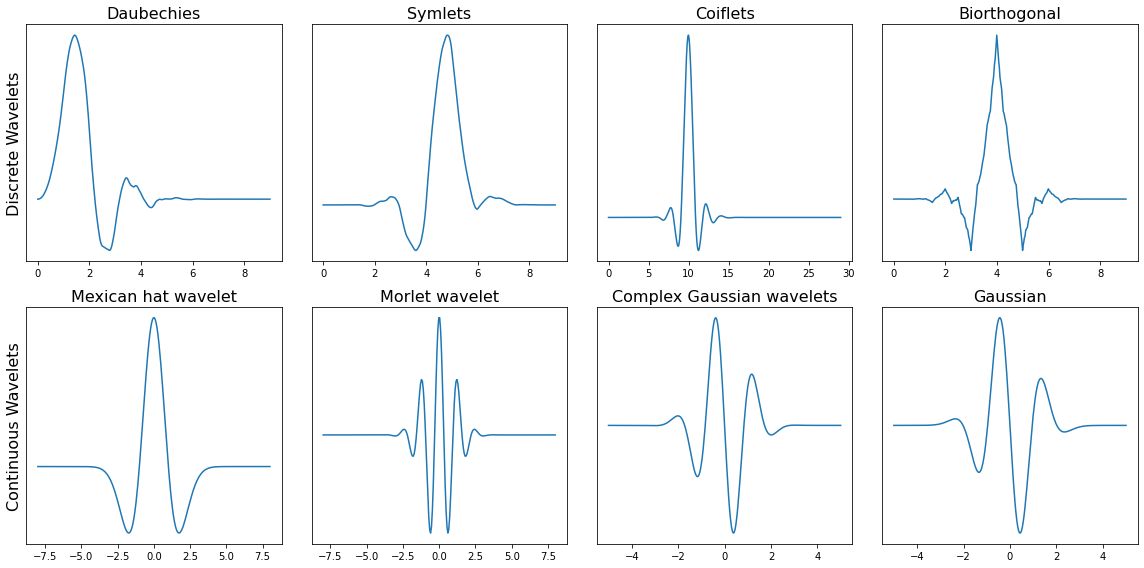

In [5]:
fig, axarr = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
for ii, list_wavelets in enumerate(list_list_wavelets):
    func = list_funcs[ii]
    row_no = ii
    for col_no, waveletname in enumerate(list_wavelets):
        wavelet = func(waveletname)
        family_name = wavelet.family_name
        biorthogonal = wavelet.biorthogonal
        orthogonal = wavelet.orthogonal
        symmetry = wavelet.symmetry
        if ii == 0:
            _ = wavelet.wavefun()
            wavelet_function = _[0]
            x_values = _[-1]
        else:
            wavelet_function, x_values = wavelet.wavefun()
        if col_no == 0 and ii == 0:
            axarr[row_no, col_no].set_ylabel("Discrete Wavelets", fontsize=16)
        if col_no == 0 and ii == 1:
            axarr[row_no, col_no].set_ylabel("Continuous Wavelets", fontsize=16)
        axarr[row_no, col_no].set_title("{}".format(family_name), fontsize=16)
        axarr[row_no, col_no].plot(x_values, wavelet_function)
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])

plt.tight_layout()
plt.show()

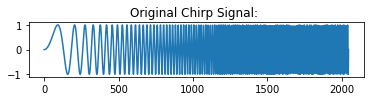

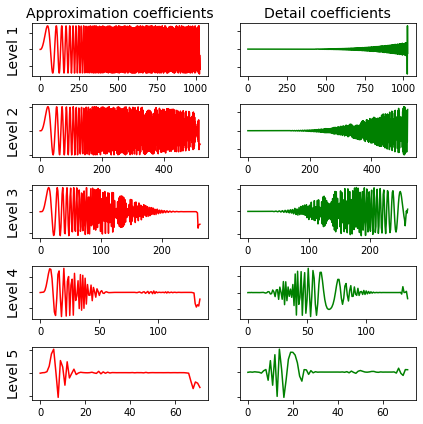

In [6]:
x = np.linspace(0, 1, num=2048)
chirp_signal = np.sin(250 * np.pi * x**2)
    
fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Chirp Signal: ")
ax.plot(chirp_signal)
plt.show()
    
data = chirp_signal
waveletname = 'sym5'

fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
for ii in range(5):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

NameError: name 'get_ave_values' is not defined

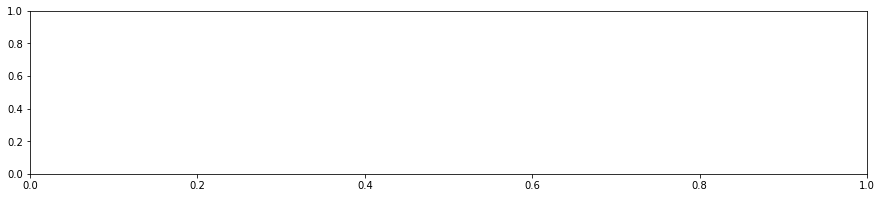

In [9]:
def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (years)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()

def plot_signal_plus_average(time, signal, average_over = 5):
    fig, ax = plt.subplots(figsize=(15, 3))
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Signal Amplitude', fontsize=18)
    ax.set_title('Signal + Time Average', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    ax.legend()
    plt.show()
    
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def plot_fft_plus_power(time, signal):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    fig, ax = plt.subplots(figsize=(15, 3))
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2     # FFT power spectrum
    ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
    ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=18)
    ax.legend()
    plt.show()

dataset = "http://paos.colorado.edu/research/wavelets/wave_idl/sst_nino3.dat"
df_nino = pd.read_table(dataset)
N = df_nino.shape[0]
t0=1871
dt=0.25
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()

scales = np.arange(1, 128)
plot_signal_plus_average(time, signal)
plot_fft_plus_power(time, signal)
plot_wavelet(time, signal, scales)